In [2]:
import pandas as pd
import itertools
from sklearn.manifold import TSNE
from leven import levenshtein
import seaborn as sns
import matplotlib.pyplot as plt
import umap
%matplotlib inline

In [3]:
inpath = "data/epitope-predictions/archive/mhcnuggets.csv"

df = pd.read_csv(inpath)

display(df)

,allele,ic50,name,peptide,pos,rank
0,HLA-A01:01,2933.23,YP_173242.1,FSDGQGVPIAF,78,1.0
1,HLA-A01:01,5287.00,YP_173242.1,MADEIANLVLA,230,2.0
2,HLA-A01:01,5404.65,YP_173242.1,YSWFSGITQFQ,61,3.0
3,HLA-A01:01,5405.67,YP_173242.1,ELAPTPGAFFF,312,4.0
4,HLA-A01:01,5409.25,YP_173242.1,SFKTADGQQKQ,106,5.0
...,...,...,...,...,...,...
52619,HLA-B08:01,38784.20,YP_009724397.2,YKTFPPTEPKK,359,405.0
52620,HLA-B08:01,38856.74,YP_009724397.2,GGPSDSTGSNQ,17,406.0
52621,HLA-B08:01,38907.21,YP_009724397.2,EVTPSGTWLTY,322,407.0
52622,HLA-B08:01,38954.47,YP_009724397.2,TNSSPDDQIGY,75,408.0


In [4]:
df.groupby('name').size()

name
NP_073556.1        9854
YP_003771.1        9542
YP_009555245.1    11388
YP_009724397.2    10634
YP_173242.1       11206
dtype: int64

In [5]:
# Concatenate allele-peptide combinations
df['allele-peptide'] = df['allele'] + "-" + df['peptide']

# Get the distinct list of peptides
peptides = df.peptide.unique()

# Get the unique pairwise combinations of peptides
peptide_pairs = list(itertools.combinations(peptides, 2))

In [6]:
# Score each peptide pair
distance_threshold = 1

peptide_pairs_scored = pd.DataFrame(columns=['pair', 'distance'])

for pair in peptide_pairs:
    distance = levenshtein(pair[0], pair[1])
    if (distance <= distance_threshold):
        peptide_pairs_scored = peptide_pairs_scored.append(pd.Series(
            [pair, distance], 
             index=peptide_pairs_scored.columns), 
             ignore_index=True)
     
display(peptide_pairs_scored)

,pair,distance
0,"(ELAPTPGAFFF, ELAPTAGAFFF)",1
1,"(PHYSWFSGITQ, PYYSWFSGITQ)",1
2,"(RRSFKTADGQQ, RRSFKTADGNQ)",1
3,"(QQCFGKRGPSQ, QQCFGKRGPNQ)",1
4,"(AIPTRFPPGTI, AIPTRFPPGTV)",1
...,...,...
78,"(LGTGPHKDLKF, LGTGPHKDAKF)",1
79,"(GTGPHKDLKFR, GTGPHKDAKFR)",1
80,"(VHFYYLGTGPH, LHFYYLGTGPH)",1
81,"(YLGTGPHKDLK, YLGTGPHKDAK)",1


In [7]:
peptide_pairs_scored[['p1', 'p2']] = pd.DataFrame(peptide_pairs_scored['pair'].tolist(), index=peptide_pairs_scored.index)

In [8]:
for row in peptide_pairs_scored.iterrows():
    p1 = row[1][2]
    p2 = row[1][3]
    peptide_pairs_scored['p1'] = peptide_pairs_scored['p1'].replace(p2,p1)
    df['peptide'] = df['peptide'].replace(p2,p1)

In [9]:
pivoted = df.pivot_table('ic50', 'name', 'allele-peptide', aggfunc=pd.Series.nunique) 

pivoted = pivoted.loc[:,(pivoted.sum() > 1)]
pivoted = pivoted.fillna(0)
display(pivoted)

allele-peptide,HLA-A01:01-DPQFPILAELA,HLA-A01:01-EAIPTRFPPGT,HLA-A01:01-FYYLGTGPHKD,HLA-A01:01-HFYYLGTGPHK,HLA-A01:01-LLPRWYFYYLG,HLA-A01:01-LPRWYFYYLGT,HLA-A01:01-PQFPILAELAP,HLA-A01:01-PRWYFYYLGTG,HLA-A01:01-QFPILAELAPT,HLA-A01:01-QLLPRWYFYYL,...,HLA-B58:01-LLPRWYFYYLG,HLA-B58:01-LPRWYFYYLGT,HLA-B58:01-PQFPILAELAP,HLA-B58:01-PRWYFYYLGTG,HLA-B58:01-QFPILAELAPT,HLA-B58:01-QLLPRWYFYYL,HLA-B58:01-RWYFYYLGTGP,HLA-B58:01-SWFSGITQFQK,HLA-B58:01-WFSGITQFQKG,HLA-B58:01-YSWFSGITQFQ
name,,,,,,,,,,,,,,,,,,,,,
NP_073556.1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YP_003771.1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YP_009555245.1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
YP_009724397.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
YP_173242.1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
tsne_results = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(pivoted)

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.001s...
[t-SNE] Computed neighbors for 5 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 35.914833
[t-SNE] KL divergence after 300 iterations: 0.121440


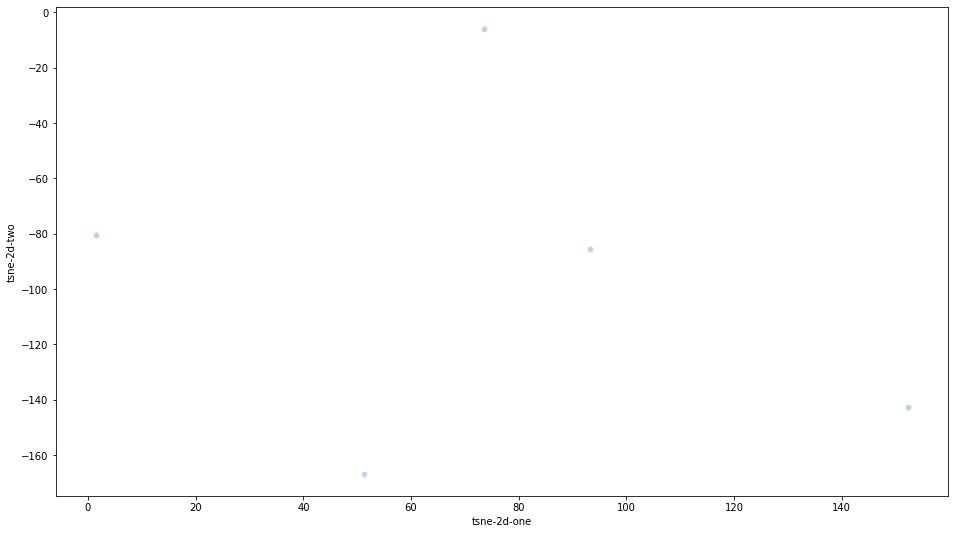

In [21]:
plt.rcParams["figure.figsize"] = (16,9)

plot_df = pd.DataFrame()
plot_df['tsne-2d-one'] = tsne_results[:,0]
plot_df['tsne-2d-two'] = tsne_results[:,1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=plot_df,
    legend="full",
    alpha=0.3
)

In [22]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(pivoted)

/home/zeth/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1674: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


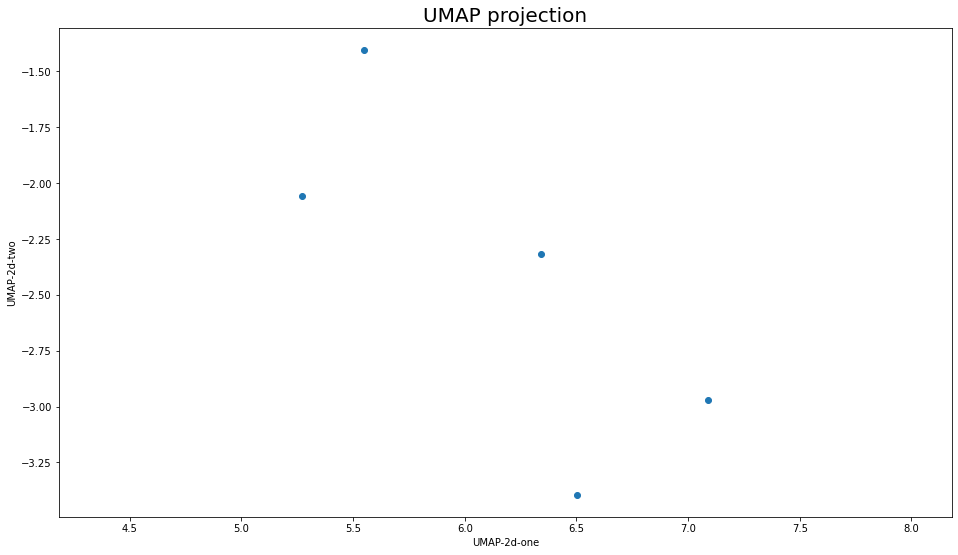

In [24]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.xlabel('UMAP-2d-one')
plt.ylabel('UMAP-2d-two')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=20);